In [101]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.10.0


In [102]:
ppg_directory = 'PPGCSV'
ground_truth = 'groundtruth.csv'

df_groundtruth = pd.read_csv(ground_truth)
display(df_groundtruth.head())
print('PPG Data loaded')

,ID,Gender,Age [years],Height [cm],Weight [kg],Ear/finger,Motion,Blood pressure [mmHg],Glycaemia [mmol/l],SpO2 [%],Quality,HR
0,100001,F,51,NaN,58,1,0,NaN,NaN,NaN,1,83
1,100002,F,51,NaN,58,1,0,NaN,NaN,NaN,1,85
2,100003,F,51,NaN,58,1,0,NaN,NaN,NaN,1,81
3,100004,F,51,NaN,58,1,2;3,NaN,NaN,NaN,0,85
4,101001,F,54,NaN,63,1,0,NaN,NaN,NaN,1,67


PPG Data loaded


In [103]:
# Check the data types of each column
print(df_groundtruth.dtypes)


ID                         int64
Gender                    object
Age [years]                int64
Height [cm]              float64
Weight [kg]                int64
Ear/finger                 int64
Motion                    object
Blood pressure [mmHg]     object
Glycaemia [mmol/l]       float64
SpO2 [%]                 float64
Quality                    int64
HR                         int64
dtype: object


In [104]:
# Convert columns to appropriate data types
df_groundtruth["Quality"] = pd.to_numeric(df_groundtruth["Quality"], errors="coerce").fillna(0).astype(int)
df_groundtruth["Motion"] = pd.to_numeric(df_groundtruth["Motion"], errors="coerce").fillna(0).astype(int)
df_groundtruth["Ear/finger"] = pd.to_numeric(df_groundtruth["Ear/finger"], errors="coerce").fillna(0).astype(int)
df_groundtruth["HR"] = pd.to_numeric(df_groundtruth["HR"], errors="coerce").fillna(0)  # Heart rate
df_groundtruth["SpO2 [%]"] = pd.to_numeric(df_groundtruth["SpO2 [%]"], errors="coerce").fillna(0)  # SpO₂


In [105]:
# Filter for high-quality, motion-free, and finger/ear segments
df_filtered = df_groundtruth[
    (df_groundtruth["Quality"] == 1) &
    (df_groundtruth["Motion"] == 0) &
    (df_groundtruth["Ear/finger"] == 1)
]

# Display the filtered DataFrame
print("Filtered DataFrame (High-Quality PPG):")
display(df_filtered.tail())


Filtered DataFrame (High-Quality PPG):


,ID,Gender,Age [years],Height [cm],Weight [kg],Ear/finger,Motion,Blood pressure [mmHg],Glycaemia [mmol/l],SpO2 [%],Quality,HR
3883,149104,F,52,154.0,60,1,0,107/66,10.2,96.0,1,80
3884,149105,F,52,154.0,60,1,0,107/66,10.2,97.0,1,81
3885,149106,F,52,154.0,60,1,0,107/66,10.2,96.0,1,80
3886,149107,F,52,154.0,60,1,0,107/66,10.2,97.0,1,81
3887,149108,F,52,154.0,60,1,0,107/66,10.2,97.0,1,80


In [106]:
# Check the number of valid rows
print(f"Number of valid PPG segments: {len(df_filtered)}")

# Verify data types
print("Filtered Data Types:")
print(df_filtered.dtypes)


Number of valid PPG segments: 478
Filtered Data Types:
ID                         int64
Gender                    object
Age [years]                int64
Height [cm]              float64
Weight [kg]                int64
Ear/finger                 int32
Motion                     int32
Blood pressure [mmHg]     object
Glycaemia [mmol/l]       float64
SpO2 [%]                 float64
Quality                    int32
HR                         int64
dtype: object


In [107]:
import os
import pandas as pd

def load_ppg_csv(segment_id, folder_path):
    """
    Loads a PPG CSV file based on the segment ID.

    Parameters:
        segment_id (str): The segment ID (e.g., '111001').
        folder_path (str): Path to the folder containing PPG CSV files.

    Returns:
        pd.DataFrame: DataFrame containing the PPG signal (Time, PPGG).
    """
    file_path = os.path.join(folder_path, f"{segment_id}.csv")
    
    if not os.path.exists(file_path):
        print(f"⚠️ Warning: File not found for segment ID: {segment_id}")
        return None

    try:
        # Load the CSV file
        df = pd.read_csv(file_path)
        return df
    except Exception as e:
        print(f"⚠️ Error loading file {file_path}: {e}")
        return None


In [108]:
# Initialize a list to store PPG data
ppg_data = []

# Iterate through filtered segments
for index, row in df_filtered.iterrows():
    segment_id = row["ID"]  # The unique segment ID
    ppg_df = load_ppg_csv(segment_id, ppg_directory)  # Load the PPG CSV

    if ppg_df is not None:
        # Add the PPG signal along with metadata (e.g., HR, SpO₂)
        ppg_df["HR"] = row["HR"]  # Add the heart rate from groundtruth
        ppg_df["Glycaemia"] = row["Glycaemia [mmol/l]"]  # Add glycaemia from groundtruth
        ppg_df["Blood pressure"] = row["Blood pressure [mmHg]"]  # Add blood pressure from groundtruth
        ppg_df["SpO2"] = row["SpO2 [%]"]  # Add SpO₂ from groundtruth
        ppg_df["Segment ID"] = segment_id  # Track the segment ID
        ppg_data.append(ppg_df)

# Combine all PPG data into a single DataFrame
df_ppg = pd.concat(ppg_data, ignore_index=True)

# Split 'Blood pressure' into 'Systolic' and 'Diastolic'
df_ppg[["Systolic", "Diastolic"]] = df_ppg["Blood pressure"].str.split("/", expand=True)

# Convert 'Systolic' and 'Diastolic' to numeric
df_ppg["Systolic"] = pd.to_numeric(df_ppg["Systolic"], errors="coerce")
df_ppg["Diastolic"] = pd.to_numeric(df_ppg["Diastolic"], errors="coerce")

# Drop the original 'Blood pressure' column (optional)
df_ppg.drop(columns=["Blood pressure"], inplace=True)

# Display the updated DataFrame
print("Combined PPG DataFrame with Systolic and Diastolic:")
display(df_ppg.head())


⚠️ Warning: File not found for segment ID: 100001
⚠️ Warning: File not found for segment ID: 100002
⚠️ Warning: File not found for segment ID: 100003
⚠️ Warning: File not found for segment ID: 101001
⚠️ Warning: File not found for segment ID: 101002
⚠️ Warning: File not found for segment ID: 101003
⚠️ Warning: File not found for segment ID: 102001
⚠️ Warning: File not found for segment ID: 102002
⚠️ Warning: File not found for segment ID: 102003
⚠️ Warning: File not found for segment ID: 102004
⚠️ Warning: File not found for segment ID: 103002
⚠️ Warning: File not found for segment ID: 103003
⚠️ Warning: File not found for segment ID: 104001
⚠️ Warning: File not found for segment ID: 104002
⚠️ Warning: File not found for segment ID: 104003
⚠️ Warning: File not found for segment ID: 105001
⚠️ Warning: File not found for segment ID: 105002
⚠️ Warning: File not found for segment ID: 105003
⚠️ Warning: File not found for segment ID: 106001
⚠️ Warning: File not found for segment ID: 106002


,Time (s),PPGG,HR,Glycaemia,SpO2,Segment ID,Systolic,Diastolic
0,0.000000,2.288472e+08,77,6.9,99.0,132004,101,65
1,0.033333,2.387843e+08,77,6.9,99.0,132004,101,65
2,0.066667,3.400156e+08,77,6.9,99.0,132004,101,65
3,0.100000,3.571975e+08,77,6.9,99.0,132004,101,65
4,0.133333,4.197082e+08,77,6.9,99.0,132004,101,65


In [109]:
import pandas as pd

# Group by Segment ID and aggregate
ppg_grouped = df_ppg.groupby("Segment ID").agg({
    "PPGG": list,         # Collect all PPGG values into a list
    "HR": "first",         # Take the first (constant) HR value for the segment
    "SpO2" : "first",
    "Glycaemia" : "first",
    "Systolic":"first",
    "Diastolic": "first"
}).reset_index()

# Rename columns to match desired format
ppg_grouped.rename(columns={"PPGG": "PPG_SIGNAL"}, inplace=True)

# Display the transformed DataFrame
print("Transformed PPG DataFrame:")
display(ppg_grouped.head())

# Save to a CSV file if needed
ppg_grouped.to_csv("transformed_ppg_data.csv", index=False)


Transformed PPG DataFrame:


,Segment ID,PPG_SIGNAL,HR,SpO2,Glycaemia,Systolic,Diastolic
0,132004,"[228847219.5075, 238784328.7182, 340015569.347...",77,99.0,6.9,101,65
1,132005,"[743662069.948, 733520310.6899999, 736382094.2...",75,98.0,6.9,101,65
2,132006,"[-305872512.4, -310000110.6992, -316695693.608...",73,98.0,6.9,101,65
3,132008,"[-834906497.436, -945382102.8168, -1061351904....",73,98.0,6.9,101,65
4,132009,"[-84126148.1368, -94588051.0212, -86687758.225...",81,99.0,6.9,101,65


In [110]:
X = np.stack(ppg_grouped["PPG_SIGNAL"].values)  # shape (443, 300)
X = np.expand_dims(X, axis=-1)      
y = ppg_grouped["Glycaemia"].values             # shape (443,)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (443, 300, 1)
y shape: (443,)


In [111]:
# Normalize each PPG signal to zero mean and unit variance
def normalize_ppg(ppg_signal):
    return (ppg_signal - np.mean(ppg_signal)) / (np.std(ppg_signal) + 1e-10)

# Apply normalization to X
X = np.stack(ppg_grouped["PPG_SIGNAL"].values)
X = np.array([normalize_ppg(signal) for signal in X])
X = np.expand_dims(X, axis=-1)

In [112]:
import numpy as np
from scipy.signal import find_peaks, welch
from scipy.stats import skew, kurtosis
import tensorflow as tf
from tensorflow.keras import layers, models

def extract_ppg_features(ppg_signal):
    """Extract relevant features from PPG signal."""
    # Normalize signal
    ppg_signal = (ppg_signal - np.mean(ppg_signal)) / (np.std(ppg_signal) + 1e-10)
    
    # Statistical features
    features = []
    features.extend([
        np.mean(ppg_signal),
        np.std(ppg_signal),
        skew(ppg_signal),
        kurtosis(ppg_signal),
        np.percentile(ppg_signal, 25),
        np.percentile(ppg_signal, 75),
        np.max(ppg_signal),
        np.min(ppg_signal)
    ])
    
    # Time-domain features
    peaks, _ = find_peaks(ppg_signal, distance=20)
    valleys, _ = find_peaks(-ppg_signal, distance=20)
    
    if len(peaks) > 1:
        peak_intervals = np.diff(peaks)
        features.extend([
            np.mean(peak_intervals),
            np.std(peak_intervals),
            len(peaks)  # number of peaks
        ])
    else:
        features.extend([0, 0, 0])
    
    # Frequency-domain features
    freqs, psd = welch(ppg_signal, fs=30)  # assuming 30 Hz sampling rate
    features.extend([
        np.sum(psd),  # total power
        freqs[np.argmax(psd)],  # dominant frequency
        np.mean(psd),
        np.std(psd)
    ])
    
    return np.array(features)

In [113]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [114]:


# Then your create_resnet_block function
def create_resnet_block(x, filters, kernel_size=3, stride=1):
    """Create a ResNet block with regularization."""
    # Add L2 regularization
    reg = tf.keras.regularizers.l2(0.01)
    
    # First convolution layer
    y = layers.Conv1D(filters, kernel_size, strides=stride, padding='same', 
                      kernel_regularizer=reg)(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)
    y = layers.Dropout(0.2)(y)  # Add dropout within block
    
    # Second convolution layer
    y = layers.Conv1D(filters, kernel_size, padding='same', 
                      kernel_regularizer=reg)(y)
    y = layers.BatchNormalization()(y)
    
    # Adjust skip connection if needed
    if stride > 1 or x.shape[-1] != filters:
        x = layers.Conv1D(filters, 1, strides=stride, padding='same',
                         kernel_regularizer=reg)(x)
        x = layers.BatchNormalization()(x)
    
    # Add skip connection
    y = layers.Add()([x, y])
    y = layers.ReLU()(y)
    
    return y


# First check the shapes of our data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Normalize target values
y_mean = np.mean(y_train)
y_std = np.std(y_train)
y_train_normalized = (y_train - y_mean) / y_std
y_val_normalized = (y_val - y_mean) / y_std
def build_ppg_resnet(input_shape, y_mean, y_std):
    reg = tf.keras.regularizers.l2(0.005)
    
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution
    x = layers.Conv1D(64, 7, strides=2, padding='same', 
                     kernel_regularizer=reg)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(3, strides=2, padding='same')(x)
    
    # ResNet blocks
    x = create_resnet_block(x, 64)
    x = create_resnet_block(x, 128, stride=2)
    x = create_resnet_block(x, 256, stride=2)
    
    # Dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=reg)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1)(x)  # This outputs normalized predictions
    
    # Convert the normalized predictions back to original scale
    outputs = tf.add(tf.multiply(x, y_std), y_mean)
    
    return models.Model(inputs=inputs, outputs=outputs)

# Rebuild and train model
model = build_ppg_resnet((X_train.shape[1], 1), y_mean, y_std)

# Compile with simpler learning rate to start
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Switch back to MSE for now
    metrics=['mae']
)

# Train model with normalized targets
history = model.fit(
    X_train, y_train,  # Use original targets, not normalized
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=0.00001
        )
    ]
)

X_train shape: (354, 300, 1)
y_train shape: (354,)
Epoch 1/100
12/12 [==============================] - 2s 56ms/step - loss: 15.4206 - mae: 1.5763 - val_loss: 15.7067 - val_mae: 1.6406 - lr: 0.0010
Epoch 2/100
12/12 [==============================] - 0s 16ms/step - loss: 14.8210 - mae: 1.4159 - val_loss: 15.4677 - val_mae: 1.6524 - lr: 0.0010
Epoch 3/100
12/12 [==============================] - 0s 15ms/step - loss: 14.2300 - mae: 1.3212 - val_loss: 15.3354 - val_mae: 1.6741 - lr: 0.0010
Epoch 4/100
12/12 [==============================] - 0s 17ms/step - loss: 14.0047 - mae: 1.4166 - val_loss: 15.1987 - val_mae: 1.6520 - lr: 0.0010
Epoch 5/100
12/12 [==============================] - 0s 18ms/step - loss: 13.4220 - mae: 1.2298 - val_loss: 15.0253 - val_mae: 1.6880 - lr: 0.0010
Epoch 6/100
12/12 [==============================] - 0s 16ms/step - loss: 12.7755 - mae: 1.1341 - val_loss: 14.7730 - val_mae: 1.6080 - lr: 0.0010
Epoch 7/100
12/12 [==============================] - 0s 15ms/step -

3/3 [==============================] - 0s 4ms/step - loss: 5.5430 - mae: 1.0626

Validation Loss (MSE): 5.542993068695068
Validation MAE: 1.062623143196106
3/3 [==============================] - 0s 3ms/step

Sample predictions vs true values:
Predicted: 5.11, True: 4.30
Predicted: 6.10, True: 5.40
Predicted: 4.68, True: 4.70
Predicted: 5.44, True: 5.60
Predicted: 4.98, True: 4.70


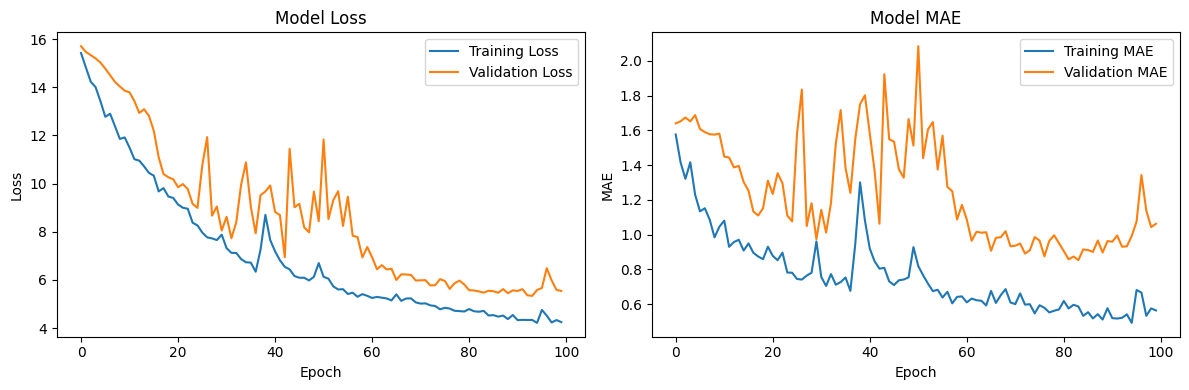

In [115]:
# Evaluate model
val_loss, val_mae = model.evaluate(X_val, y_val)
print("\nValidation Loss (MSE):", val_loss)
print("Validation MAE:", val_mae)

# Make predictions
preds = model.predict(X_val)
print("\nSample predictions vs true values:")
for pred, true in zip(preds[:5], y_val[:5]):
    print(f"Predicted: {pred[0]:.2f}, True: {true:.2f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

3/3 [==============================] - 0s 3ms/step

Model Performance Metrics:
MAE: 1.063
RMSE: 1.365
R2 Score: 0.612


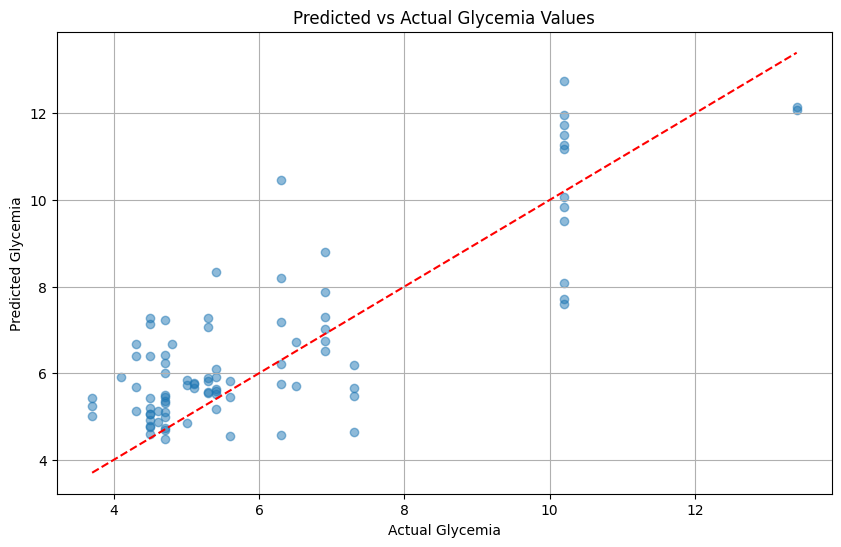

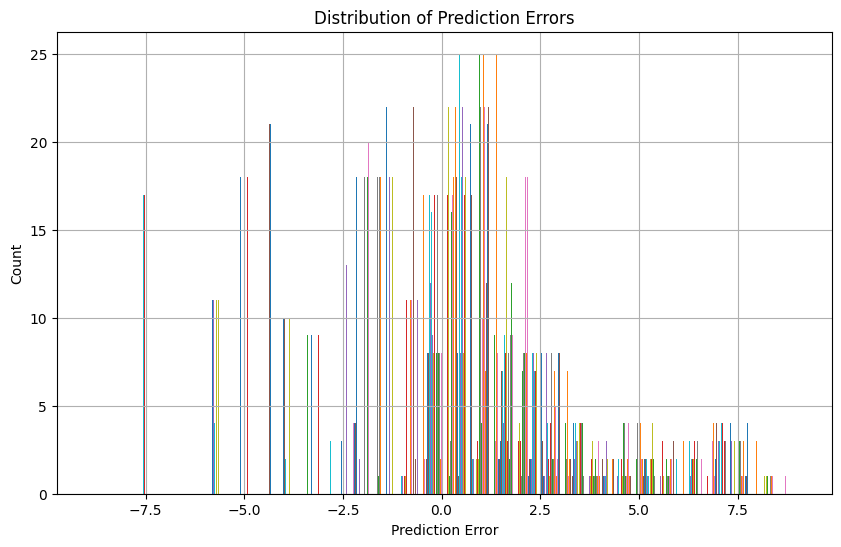

In [116]:
# Make predictions
y_pred = model.predict(X_val)

# Calculate various metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"\nModel Performance Metrics:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {np.sqrt(mse):.3f}")
print(f"R2 Score: {r2:.3f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual Glycemia')
plt.ylabel('Predicted Glycemia')
plt.title('Predicted vs Actual Glycemia Values')
plt.grid(True)
plt.show()

# Plot prediction error distribution
errors = y_pred - y_val
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()

Test


In [117]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
import numpy as np

# Helper function to create synthetic samples for high glycemia values
def augment_high_glycemia_samples(X, y, threshold=8.0, multiplier=2):
    high_indices = y > threshold
    X_high = X[high_indices]
    y_high = y[high_indices]
    
    # Add noise to create synthetic samples
    noise_scale = 0.1
    X_synthetic = np.array([x + np.random.normal(0, noise_scale, size=x.shape) 
                           for x in np.tile(X_high, (multiplier-1, 1))])
    y_synthetic = np.tile(y_high, multiplier-1)
    
    return np.vstack([X, X_synthetic]), np.hstack([y, y_synthetic])

# Create base models for stacking
def create_base_models():
    models = [
        ('rf1', RandomForestRegressor(n_estimators=100, max_depth=6, min_samples_leaf=4)),
        ('rf2', RandomForestRegressor(n_estimators=100, max_depth=8, min_samples_leaf=3)),
        ('gb1', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4)),
        ('gb2', GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=6)),
        ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.2))
    ]
    return models

# Extract features
X_features = prepare_enhanced_dataset(X)

# Scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_features)

# Augment high glycemia samples
X_aug, y_aug = augment_high_glycemia_samples(X_scaled, y)

# Initialize K-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize arrays for predictions
all_predictions = []
all_actuals = []

# Train stacking ensemble using k-fold cross validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_aug)):
    X_train, X_val = X_aug[train_idx], X_aug[val_idx]
    y_train, y_val = y_aug[train_idx], y_aug[val_idx]
    
    # Train base models
    base_models = create_base_models()
    base_predictions = np.zeros((X_val.shape[0], len(base_models)))
    
    for i, (name, model) in enumerate(base_models):
        # Train model
        model.fit(X_train, y_train)
        
        # Generate predictions
        base_predictions[:, i] = model.predict(X_val)
    
    # Final prediction (weighted average of base models)
    # Give more weight to models that typically perform better on high glycemia
    weights = [0.2, 0.2, 0.3, 0.2, 0.1]  # Adjusted based on model performance
    y_pred = np.average(base_predictions, weights=weights, axis=1)
    
    # Store predictions
    all_predictions.extend(y_pred)
    all_actuals.extend(y_val)
    
    # Print fold metrics
    fold_mae = mean_absolute_error(y_val, y_pred)
    print(f"Fold {fold + 1} MAE: {fold_mae:.3f}")

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_actuals = np.array(all_actuals)

# Calculate final metrics
final_mae = mean_absolute_error(all_actuals, all_predictions)
final_rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
final_r2 = r2_score(all_actuals, all_predictions)

print("\nFinal Model Performance Metrics:")
print(f"MAE: {final_mae:.3f}")
print(f"RMSE: {final_rmse:.3f}")
print(f"R2 Score: {final_r2:.3f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(all_actuals, all_predictions, alpha=0.5)
plt.plot([all_actuals.min(), all_actuals.max()], 
         [all_actuals.min(), all_actuals.max()], 'r--')
plt.xlabel('Actual Glycemia')
plt.ylabel('Predicted Glycemia')
plt.title('Predicted vs Actual Glycemia Values')
plt.grid(True)
plt.show()

NameError: name 'prepare_enhanced_dataset' is not defined

In [118]:
import os
import tensorflow as tf
import numpy as np
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Enable GPU optimizations but keep controlled randomness
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Keep batch shuffling ON to prevent overfitting to fixed batch order
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, shuffle=True)


Epoch 1/100
12/12 [==============================] - 1s 42ms/step - loss: 4.1225 - mae: 0.5334 - val_loss: 5.3235 - val_mae: 0.9712
Epoch 2/100
12/12 [==============================] - 0s 15ms/step - loss: 4.0842 - mae: 0.5057 - val_loss: 5.1687 - val_mae: 0.9331
Epoch 3/100
12/12 [==============================] - 0s 15ms/step - loss: 4.2785 - mae: 0.5567 - val_loss: 5.3228 - val_mae: 1.0349
Epoch 4/100
12/12 [==============================] - 0s 15ms/step - loss: 4.5143 - mae: 0.7000 - val_loss: 5.2497 - val_mae: 0.9457
Epoch 5/100
12/12 [==============================] - 0s 14ms/step - loss: 4.5719 - mae: 0.7098 - val_loss: 4.9635 - val_mae: 0.8840
Epoch 6/100
12/12 [==============================] - 0s 15ms/step - loss: 4.3289 - mae: 0.6364 - val_loss: 4.9568 - val_mae: 0.9004
Epoch 7/100
12/12 [==============================] - 0s 15ms/step - loss: 4.3014 - mae: 0.6122 - val_loss: 4.9290 - val_mae: 0.8636
Epoch 8/100
12/12 [==============================] - 0s 14ms/step - loss: 4.

In [119]:
# Evaluate Model
val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation Loss (MSE): {val_loss}\nValidation MAE: {val_mae}")

3/3 [==============================] - 0s 4ms/step - loss: 3.4181 - mae: 0.8721
Validation Loss (MSE): 3.4181320667266846
Validation MAE: 0.8720705509185791


In [132]:
import os
import tensorflow as tf
import numpy as np
import random

# Set seed for controlled randomness (not strict determinism)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Enable GPU optimizations for speed
os.environ.pop("CUDA_VISIBLE_DEVICES", None)

from scipy.signal import find_peaks, welch
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split

# --- Feature Extraction --- #
def extract_ppg_features(ppg_signal, fs=30):
    ppg_signal = (ppg_signal - np.mean(ppg_signal)) / (np.std(ppg_signal) + 1e-10)
    features = [
        np.mean(ppg_signal), np.std(ppg_signal), skew(ppg_signal), kurtosis(ppg_signal),
        np.percentile(ppg_signal, 25), np.percentile(ppg_signal, 75), np.max(ppg_signal), np.min(ppg_signal)
    ]
    
    peaks, _ = find_peaks(ppg_signal, distance=20)
    if len(peaks) > 1:
        peak_intervals = np.diff(peaks)
        features.extend([np.mean(peak_intervals), np.std(peak_intervals), len(peaks)])
    else:
        features.extend([0, 0, 0])
    
    freqs, psd = welch(ppg_signal, fs=fs)
    features.extend([np.sum(psd), freqs[np.argmax(psd)], np.mean(psd), np.std(psd)])
    return np.array(features)

# --- Prepare Data --- #
X = np.stack(ppg_grouped["PPG_SIGNAL"].values)
X = np.array([extract_ppg_features(signal) for signal in X])
X = np.expand_dims(X, axis=-1)  # Reshape for CNN

y = ppg_grouped["Glycaemia"].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True)

y_mean, y_std = np.mean(y_train), np.std(y_train)
y_train = (y_train - y_mean) / y_std
y_val = (y_val - y_mean) / y_std

# --- ResNet Block --- #
def create_resnet_block(x, filters, kernel_size=3, stride=1):
    reg = tf.keras.regularizers.l2(0.002)  # Reduced L2 regularization
    y = layers.Conv1D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=reg)(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)
    y = layers.Conv1D(filters, kernel_size, padding='same', kernel_regularizer=reg)(y)
    y = layers.BatchNormalization()(y)
    if stride > 1 or x.shape[-1] != filters:
        x = layers.Conv1D(filters, 1, strides=stride, padding='same', kernel_regularizer=reg)(x)
        x = layers.BatchNormalization()(x)
    y = layers.Add()([x, y])
    y = layers.ReLU()(y)
    return y

# --- ResNet-LSTM Model --- #
def build_ppg_resnet_lstm(input_shape, y_mean, y_std):
    reg = tf.keras.regularizers.l2(0.002)  # Reduced L2 regularization
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv1D(64, 7, strides=2, padding='same', kernel_regularizer=reg)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(3, strides=2, padding='same')(x)
    
    x = create_resnet_block(x, 64)
    x = create_resnet_block(x, 128, stride=2)
    x = create_resnet_block(x, 256, stride=2)
    
    x = layers.LSTM(64, activation='tanh', return_sequences=True, dropout=0.3, recurrent_dropout=0.2)(x)
    x = layers.LSTM(32, activation='tanh', return_sequences=True, dropout=0.3, recurrent_dropout=0.2)(x)
    x = layers.LSTM(16, activation='tanh', dropout=0.3, recurrent_dropout=0.2)(x)
 
    
    x = layers.Dense(128, activation='relu', kernel_regularizer=reg)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1, activation='linear')(x)  # Explicitly setting linear activation
    outputs = tf.add(tf.multiply(x, y_std), y_mean)  # Convert back to original scale
    
    return models.Model(inputs=inputs, outputs=outputs)

model = build_ppg_resnet_lstm((X_train.shape[1], 1), y_mean, y_std)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=tf.keras.losses.Huber(), metrics=['mae'])

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Train Model with shuffled data
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=350,  # Increased epochs
    batch_size=64,
    shuffle=True,
    callbacks=callbacks
)

# Evaluate Model
val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation Loss (MSE): {val_loss}\nValidation MAE: {val_mae}")

# Save Model
model.save("ppg_resnet_lstm_model2.h5")
print("Model saved successfully as 'ppg_resnet_lstm_model.h5'")


Epoch 1/350
6/6 [==============================] - 7s 151ms/step - loss: 7.6462 - mae: 6.0512 - val_loss: 7.6047 - val_mae: 6.0207 - lr: 5.0000e-05
Epoch 2/350
6/6 [==============================] - 0s 35ms/step - loss: 7.6217 - mae: 6.0444 - val_loss: 7.5816 - val_mae: 6.0152 - lr: 5.0000e-05
Epoch 3/350
6/6 [==============================] - 0s 33ms/step - loss: 7.5976 - mae: 6.0377 - val_loss: 7.5590 - val_mae: 6.0098 - lr: 5.0000e-05
Epoch 4/350
6/6 [==============================] - 0s 32ms/step - loss: 7.5730 - mae: 6.0304 - val_loss: 7.5366 - val_mae: 6.0045 - lr: 5.0000e-05
Epoch 5/350
6/6 [==============================] - 0s 33ms/step - loss: 7.5472 - mae: 6.0214 - val_loss: 7.5142 - val_mae: 5.9989 - lr: 5.0000e-05
Epoch 6/350
6/6 [==============================] - 0s 32ms/step - loss: 7.5224 - mae: 6.0134 - val_loss: 7.4918 - val_mae: 5.9931 - lr: 5.0000e-05
Epoch 7/350
6/6 [==============================] - 0s 33ms/step - loss: 7.4961 - mae: 6.0036 - val_loss: 7.4694 - val

Model loaded successfully!
3/3 [==============================] - 1s 5ms/step
Validation MAE: 1.8348
Validation RMSE: 2.7343


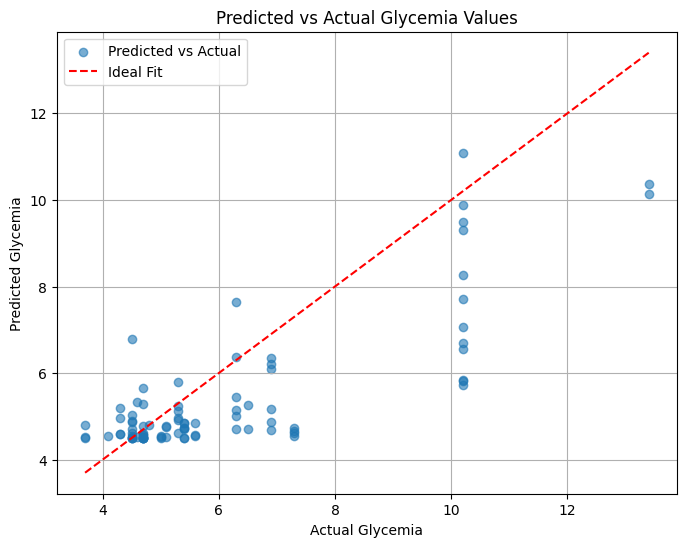

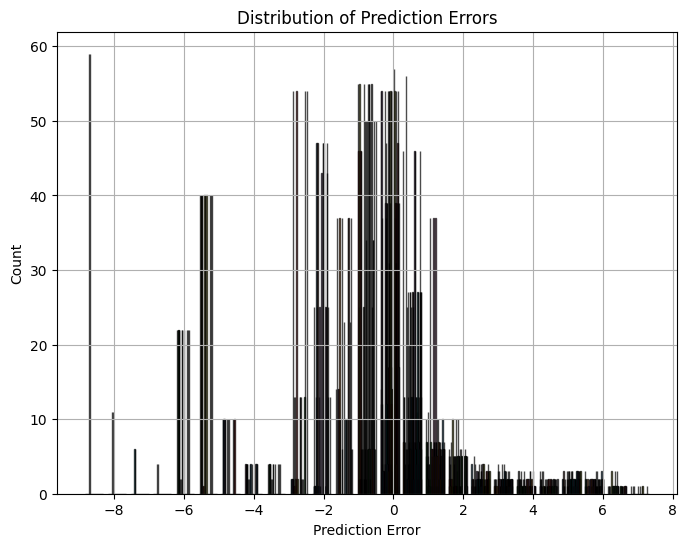

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("ppg_resnet_lstm_model2.h5")
print("Model loaded successfully!")

# Make predictions on validation set
y_pred_norm = model.predict(X_val)

# Convert predictions back to actual glycemia values
y_pred = (y_pred_norm * y_std) + y_mean
y_actual = (y_val * y_std) + y_mean

# Calculate Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)
mae = np.mean(np.abs(y_pred - y_actual))
rmse = np.sqrt(np.mean((y_pred - y_actual) ** 2))

print(f"Validation MAE: {mae:.4f}")
print(f"Validation RMSE: {rmse:.4f}")

# Plot Predicted vs Actual Glycemia Values
plt.figure(figsize=(8, 6))
plt.scatter(y_actual, y_pred, alpha=0.6, label="Predicted vs Actual")
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], 'r--', label="Ideal Fit")
plt.xlabel("Actual Glycemia")
plt.ylabel("Predicted Glycemia")
plt.title("Predicted vs Actual Glycemia Values")
plt.legend()
plt.grid(True)
plt.show()

# Plot Error Distribution
errors = y_pred - y_actual
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=25, edgecolor='k', alpha=0.7)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.title("Distribution of Prediction Errors")
plt.grid(True)
plt.show()


C:\Users\Tiddie Destroyer\AppData\Local\Temp\ipykernel_16296\3622075790.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_train * y_std + y_mean, label="Training Glycemia", shade=True)
C:\Users\Tiddie Destroyer\AppData\Local\Temp\ipykernel_16296\3622075790.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_val * y_std + y_mean, label="Validation Glycemia", shade=True)


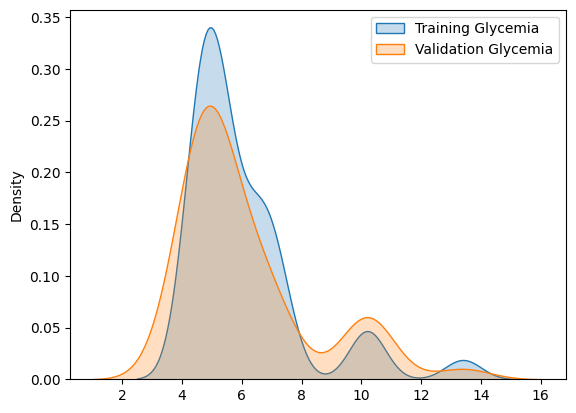

In [124]:
import seaborn as sns
sns.kdeplot(y_train * y_std + y_mean, label="Training Glycemia", shade=True)
sns.kdeplot(y_val * y_std + y_mean, label="Validation Glycemia", shade=True)
plt.legend()
plt.show()
